In [1]:
import warnings
warnings.filterwarnings('ignore')

import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

#import tokenization
#from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


SEED = 1337

print(1)

1


In [51]:
dfull = pd.read_csv('./ds/train.csv', dtype={'id': np.int16, 'target': np.int8})
dtest = pd.read_csv('./ds/test.csv', dtype={'id': np.int16, 'target': np.int8})
d1000 = dfull[:1000]
d10000 = dfull[:10000]
d100000 = dfull[:100000]


print('Training Set Shape = {}'.format(dfull.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(dfull.memory_usage().sum() / 1024**2))

Training Set Shape = (9473201, 9)
Training Set Memory Usage = 650.47 MB


In [52]:
d1000.head()

,x,y,z,t,terror,q,flag,event_id,hit_id
0,-142.5,-147.5,0,767.8790,2.02966,1.050520,0,7,1
1,-137.5,-152.5,0,-70.5552,2.02966,0.999853,0,7,2
2,-137.5,-132.5,0,-837.8410,1.85146,2.052540,0,7,3
3,-142.5,-117.5,0,-973.1950,1.39994,19.513100,0,7,4
4,-137.5,-117.5,0,-159.1400,2.02966,0.800334,0,7,5


In [55]:
print(f'Number of unique values in  event_id = {dfull["event_id"].nunique()} (Training) ')

Number of unique values in  event_id = 9300 (Training) 


In [56]:
unique, counts = np.unique(dfull['event_id'], return_counts=True)
print (np.asarray((unique, counts)).T)

[[    7   426]
 [    8   402]
 [   11   642]
 ...
 [13352  2375]
 [13353  1257]
 [13354   575]]


In [57]:
unique, counts = np.unique(dtest['event_id'], return_counts=True)
print (np.asarray((unique, counts)).T)

[[    9   432]
 [   24   403]
 [   30   477]
 ...
 [13344  1136]
 [13355   441]
 [13356   465]]


In [59]:
a =dfull['event_id']
b = dtest['event_id']

match = set(a) & set(b)
print(match)

set()


In [6]:
diabetes_data_copy = diabetes_data.copy(deep = True)
diabetes_data_copy[['x','y','t','q']] = diabetes_data_copy[['x','y','t','q']].replace(0,np.NaN)
## showing the count of Nans
print(diabetes_data_copy.isnull().sum())

x           0
y           0
z           0
t           0
terror      0
q           0
flag        0
event_id    0
hit_id      0
dtype: int64


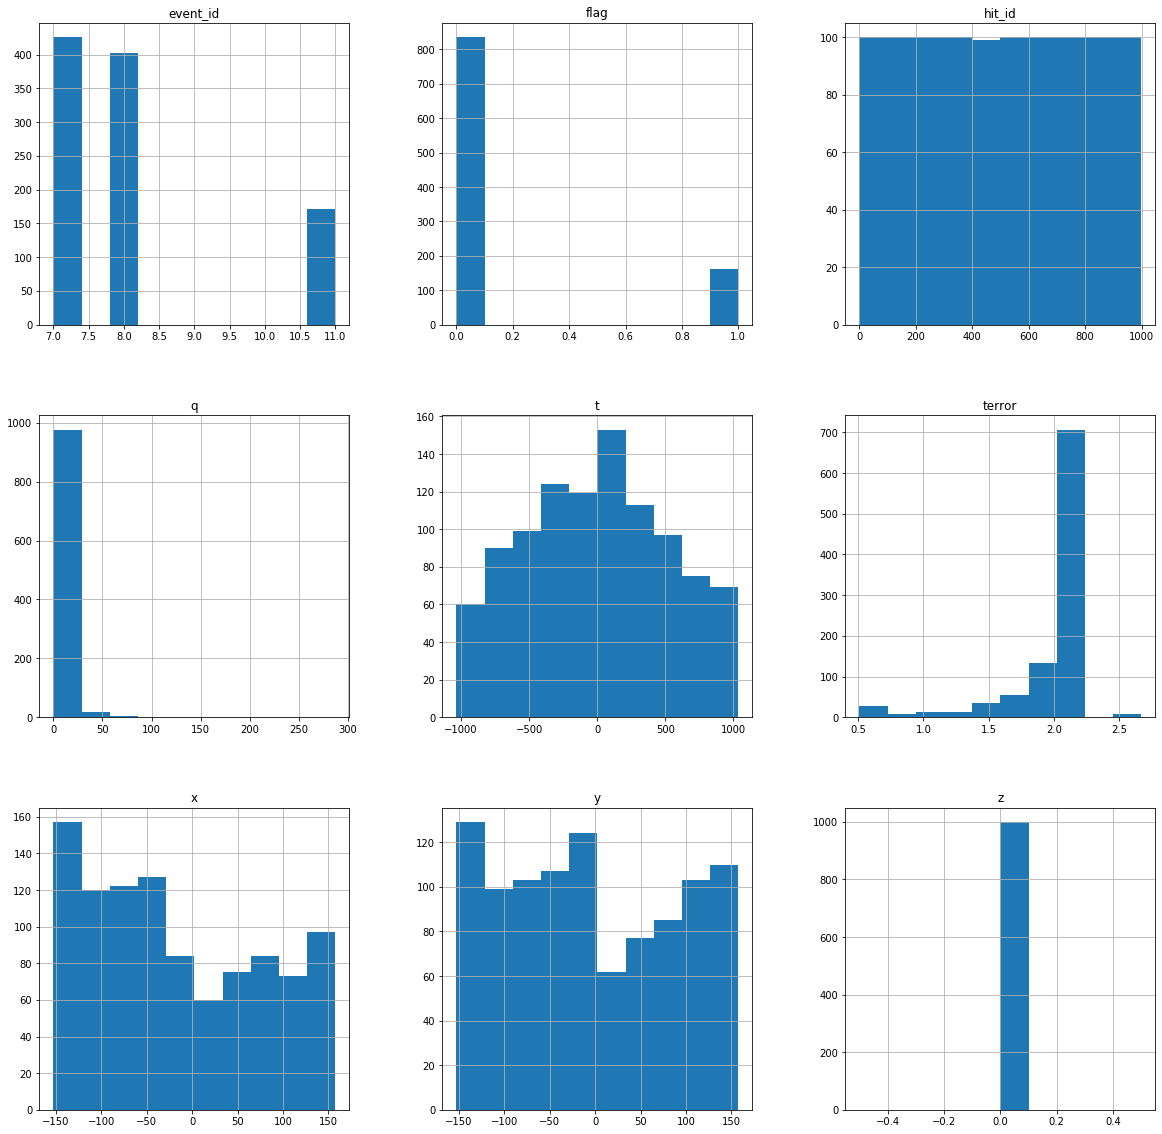

In [7]:
p = diabetes_data.hist(figsize = (20,20))


In [8]:
diabetes_data.shape

(999, 9)

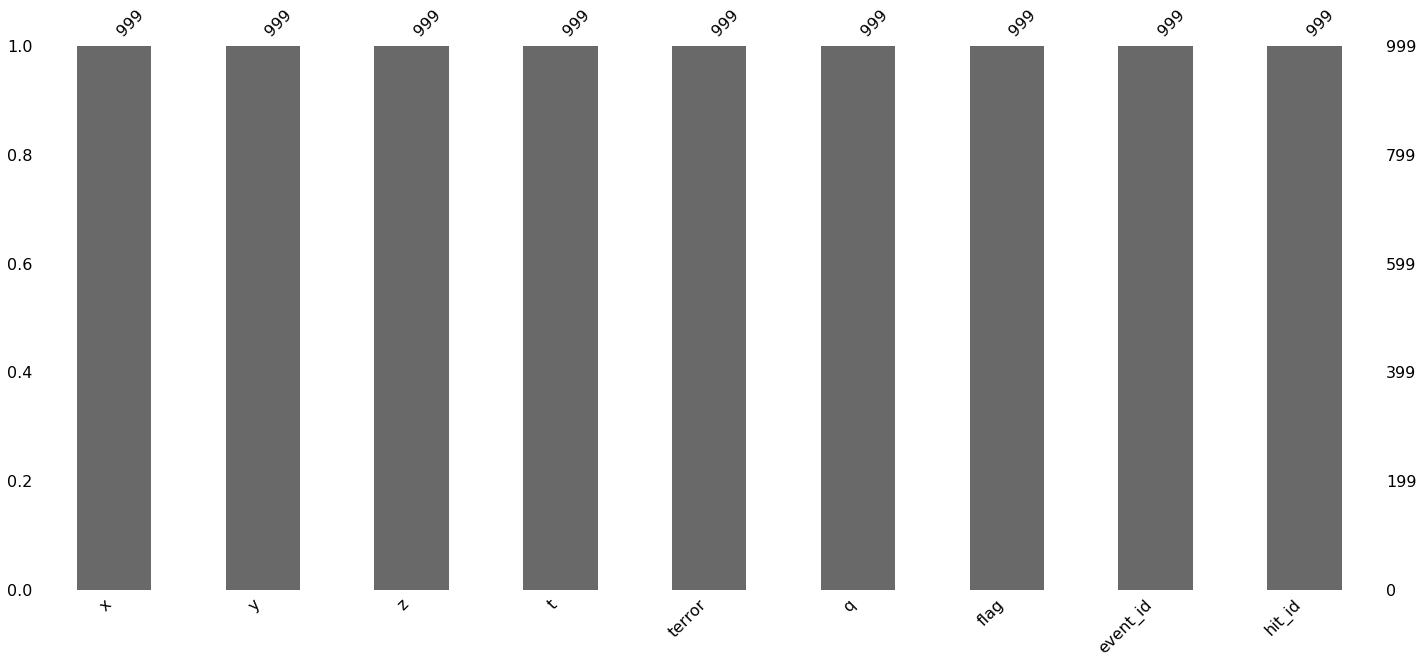

In [9]:
## null count analysis
import missingno as msno
p=msno.bar(diabetes_data)

0    836
1    163
Name: flag, dtype: int64


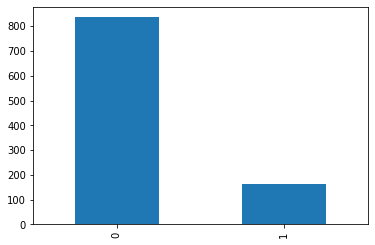

In [10]:
## checking the balance of the data by plotting the count of outcomes by their value
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = diabetes_data["flag"].map(lambda x: color_wheel.get(x + 1))
print(diabetes_data.flag.value_counts())
p=diabetes_data.flag.value_counts().plot(kind="bar")

In [11]:
# from pandas.plotting import scatter_matrix
# p=scatter_matrix(diabetes_data,figsize=(25, 25))

In [12]:
# seems like dead
# p=sns.pairplot(diabetes_data, hue = 't')

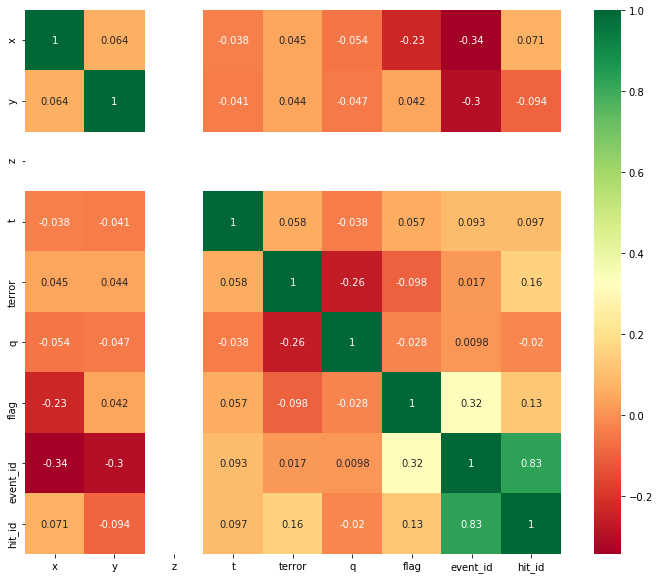

In [13]:
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(diabetes_data.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

In [14]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(diabetes_data_copy.drop(["z",'terror','flag','event_id','hit_id'],axis = 1),),
        columns=['x','y','t','q'])

In [15]:
X.head()

,x,y,t,q
0,-1.342805,-1.536352,1.462989,-0.226316
1,-1.289290,-1.589805,-0.126951,-0.230205
2,-1.289290,-1.375991,-1.581971,-0.149411
3,-1.342805,-1.215630,-1.838646,1.190693
4,-1.289290,-1.215630,-0.294936,-0.245518


In [16]:
y = diabetes_data_copy.flag

In [17]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

In [18]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [19]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [20]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 91.5915915915916 % and k = [1]


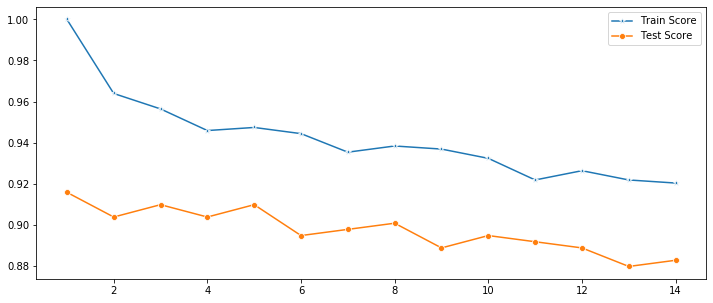

In [21]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

In [22]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(14)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.8828828828828829

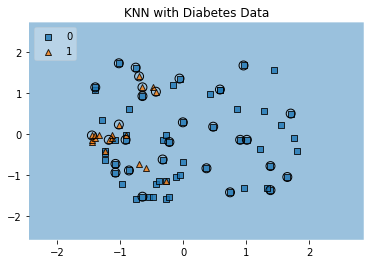

In [23]:
from mlxtend.plotting import plot_decision_regions


value = 20000
width = 20000
plot_decision_regions(X.values, y.values, clf=knn, legend=2, 
                      filler_feature_values={2: value, 3: value},
                      filler_feature_ranges={2: width, 3: width},
                      X_highlight=X_test.values)

# Adding axes annotations
#plt.xlabel('sepal length [cm]')
#plt.ylabel('petal length [cm]')
plt.title('KNN with Diabetes Data')
plt.show()

In [24]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,258,21,279
1,18,36,54
All,276,57,333


Text(0.5, 15.0, 'Predicted label')

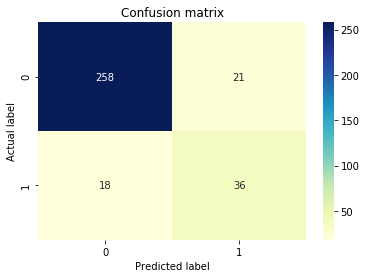

In [25]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       279
           1       0.63      0.67      0.65        54

    accuracy                           0.88       333
   macro avg       0.78      0.80      0.79       333
weighted avg       0.89      0.88      0.88       333



In [27]:
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

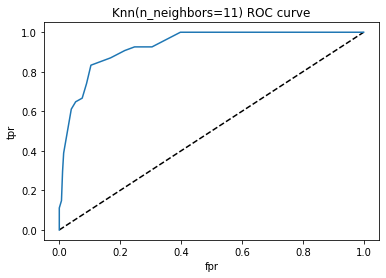

In [28]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

In [29]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.9309703969202177

In [30]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.8818542713567841
Best Parameters: {'n_neighbors': 2}
